## 第５章　音声向きAE・・・自動で精度UPするノイズ・フィルタ


In [1]:
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model

# this is our input placeholder
input_wav = Input(shape=(514,))
x = Dense(512, activation='relu')(input_wav)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
encoded = Dense(512, activation='relu')(x)

x = Dense(512, activation='relu')(encoded)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
decoded = Dense(514)(x)


Using TensorFlow backend.


In [2]:
autoencoder = Model(input_wav, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metriics=['mae'])

In [3]:
import pandas as pd
import numpy as np

# 入力データ
data = np.load('data/dae_train.npy')
noisy, org = data

train_noisy = noisy[:300]
test_noisy = noisy[300:]
train = org[:300]
test = org[300:]

print train.shape, test.shape, train_noisy.shape, test_noisy.shape

(300, 514) (74, 514) (300, 514) (74, 514)


In [4]:
history = autoencoder.fit(train_noisy, train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(test_noisy, test))

/usr/lib/sagemath/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 300 samples, validate on 74 samples
Epoch 1/100
300/300 [==============================] - 0s - loss: 0.6083 - val_loss: 0.0631
Epoch 2/100
300/300 [==============================] - 0s - loss: 0.5847 - val_loss: 0.0632
Epoch 3/100
300/300 [==============================] - 0s - loss: 0.5341 - val_loss: 0.0635
Epoch 4/100
300/300 [==============================] - 0s - loss: 0.4728 - val_loss: 0.0635
Epoch 5/100
300/300 [==============================] - 0s - loss: 0.4209 - val_loss: 0.0635
Epoch 6/100
300/300 [==============================] - 0s - loss: 0.3706 - val_loss: 0.0635
Epoch 7/100
300/300 [==============================] - 0s - loss: 0.3150 - val_loss: 0.0634
Epoch 8/100
300/300 [==============================] - 0s - loss: 0.2797 - val_loss: 0.0633
Epoch 9/100
300/300 [==============================] - 0s - loss: 0.2475 - val_loss: 0.0634
Epoch 10/100
300/300 [==============================] - 0s - loss: 0.2312 - val_loss: 0.0634
Epoch 11/100
300/300 [============

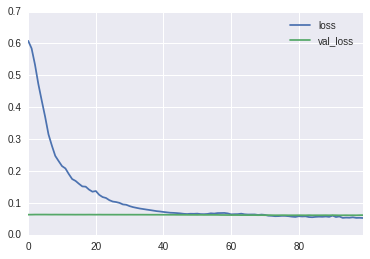

In [5]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline


# history_dictをpandasnのデータフレームに変換
d = pd.DataFrame(history.history)
# loss, val_lossをプロット
d[['loss', 'val_loss']].plot()
plt.show()

In [6]:
from scipy import ceil, complex64, float32, float64, hamming, zeros
from scipy.fftpack import fft
from scipy import ifft
import scipy.signal
from scipy.io.wavfile import read
from scipy.io.wavfile import write


In [7]:
# ================= #
#  短時間フーリエ変換  #
# ================= #
# x: 入力波形，win: 窓関数，step: フレームシフト
def STFT(x, win, step):
    l = len(x) # 入力信号の長さ
    N = len(win) # 窓幅、つまり切り出す幅
    M = int(ceil(float(l - N + step) / step)) # スペクトログラムの時間フレーム数
    new_x = zeros(N + ((M - 1) * step), dtype = float64)
    new_x[: l] = x

    X = zeros([M, N], dtype = complex64) # スペクトログラムの初期化(複素数型)
    for m in xrange(M):
        start = step * m
        X[m, :] = fft(new_x[start : start + N] * win)

    # 平均と標準偏差で正規化する（発話単位で正規化）
    X = (X - np.mean(X)) / np.std(X)
    return X

# ============= #
#  逆フーリエ変換 #
# ============= #
def iSTFT(X, win, step):
    M, N = X.shape
    l = (M - 1) * step + N
    x = zeros(l, dtype=float64)
    wsum = zeros(l, dtype=float64)
    for m in xrange(M):
        start = step * m        
        x[start : start + N] = x[start : start + N] + ifft(X[m, :]).real * win
        wsum[start : start + N] += win ** 2 
    pos = (wsum != 0)
    x_pre = x.copy()    
    x[pos] /= wsum[pos]
    return x


In [8]:
fftLen = 512 # FFTの点数
shift = 10      # 窓関数のシフト幅（単位[ms]）

# ノイズを含んだ音声データ
fs, nwave = read('data/noise.wav')

波形を表示

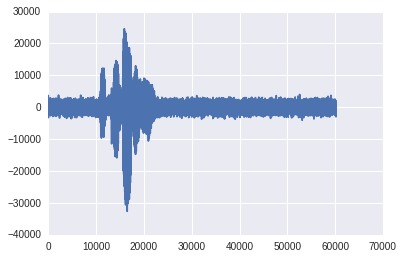

In [9]:
plt.plot(nwave)
plt.show()

In [10]:
step = int(fs * shift / 1000)     # シフト幅の設定
win = hamming(fftLen)             # ハミング窓

### STFT ###
nspec = STFT(nwave, win, step) # ノイズ重畳音声のスペクトル
length = len(nspec)
dn_spec = zeros([length, 512], dtype=complex64) # 雑音除去後のスペクトル

# クリーン音声のスペクトルをDAEの入力に合うように変換
data = []
for i in range(len(nspec)):
    re = np.array(nspec[i].real[0:fftLen/2+1], dtype=np.float32)
    im = np.array(nspec[i].imag[0:fftLen/2+1], dtype=np.float32)
    data.append(np.hstack([re, im]))
n_in = len(data[0])


In [11]:
x = np.array(data).astype(np.float32)
y = autoencoder.predict(x)

In [12]:
# 雑音除去スペクトルを複素平面に戻す
for i in xrange(0, len(y)):        
    real = y[i, 0:257]
    rev_real = real[1:257][::-1] # reverse
    image = y[i, 257:514]
    rev_image = image[1:257][::-1]
    dn_spec[i].real[0:257] = real
    dn_spec[i].real[256:512] = rev_real
    dn_spec[i].imag[0:257] = image
    dn_spec[i].imag[256:512] = rev_image

dn_wav = iSTFT(dn_spec, win, step) # 逆フーリエ変換で波形に戻す
write("data/keras_denoise.wav", 16000, dn_wav) 

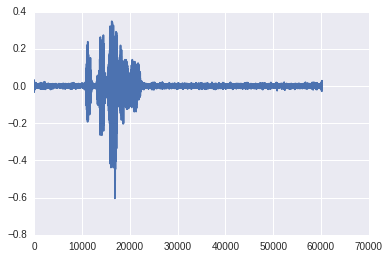

In [13]:
plt.plot(dn_wav)
plt.show()

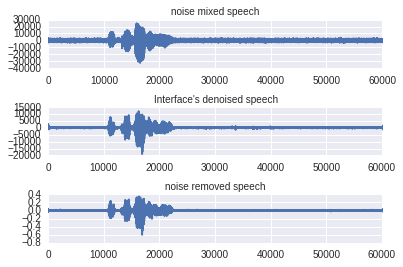

In [14]:
# Interfaceのノイズ除去された音声データ
fs, target_wave = read('data/denoise.wav')

fig = plt.figure()
fig.add_subplot(311)
plt.plot(nwave)
plt.xlim([0, len(nwave)])
plt.title("noise mixed speech", fontsize = 10)    
fig.add_subplot(312)
plt.plot(target_wave)
plt.xlim([0, len(target_wave)])
plt.title("Interface's denoised speech", fontsize = 10)
fig.add_subplot(313)
plt.plot(dn_wav)
plt.xlim([0, len(dn_wav)])
plt.title("noise removed speech", fontsize = 10)    
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()